In [14]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("structured")

LangSmith 추적을 시작합니다.
[프로젝트명]
structured


### 모듈 import

In [150]:
import pandas as pd
import os
from dotenv import load_dotenv
from langchain_teddynote import logging
from langchain.text_splitter import CharacterTextSplitter
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import LocalFileStore
from langchain_community.vectorstores import FAISS
from langchain_upstage import UpstageEmbeddings, ChatUpstage
from langchain_anthropic import ChatAnthropic
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda 
from langchain.memory import ConversationBufferMemory
from langchain.schema import Document
from datetime import datetime
from langchain_community.document_loaders import JSONLoader
import json
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_anthropic import ChatAnthropic
from langchain.schema.output_parser import StrOutputParser

## 1. 대분류 :의도파악하기

In [151]:
# 주문하고 싶은 메뉴가 있다면 메뉴 이름을 말씀해주세요. 메뉴 추천을 받고 싶다면 선호하는 맛, 식재료, 스타일 등을 구체적으로 알려주시면 더 나은 추천이 가능합니다.

intent_chain = PromptTemplate.from_template("""
아래 질문을 보고 사용자가 원하는 의도를 '주문', '추천', '취소', '결제', '기타' 중 하나로 정확하게 분류하세요.

분류 기준:
- 주문: 특정 메뉴를 정확히 주문하려는 경우 (예: '빅맥 하나 주세요', '감자튀김 추가')
- 추천: 특정 메뉴 이름 대신 추천을 요청하거나 메뉴 선택에 도움을 원하는 경우 (예: '뭐가 맛있나요?', '매콤한 음식 추천해줘')
- 취소: 이전에 진행된 주문을 취소하려는 경우 (예: '주문 취소해 주세요', '아까 주문한 것 취소하고 싶어요')
- 결제: 주문 완료 후 결제를 요청하는 경우 (예: '결제할게요', '주문 끝났어')
- 기타: 위의 네 가지 분류에 해당하지 않는 경우 (예: '화장실은 어디인가요?', '영업 시간은 언제인가요?')

<질문>
{question}
</질문>

질문의 분류와 해당 질문에 포함된 주요 키워드를 JSON 형식으로 출력하세요.

조건:
- 질문의 분류와 해당 질문에 포함된 주요 키워드를 딕셔너리 형식으로 출력하세요.
- 분류가 '주문'일 때만 키워드를 추출하세요. 다른 분류에서는 키워드를 포함하지 않습니다.

예시 출력: {{"분류": "주문", "키워드": "빅맥"}}
예시 출력: {{"분류": "추천"}}
""") | ChatUpstage() | StrOutputParser()

In [152]:
# 추가적인 파싱 작업: 문자열을 딕셔너리로 변환
import json

def parse_response(response_str):
    try:
        response_dict = json.loads(response_str)
    except json.JSONDecodeError:
        response_dict = {"error": "파싱 오류", "원본": response_str}
    return response_dict

의도한게 '주문'

In [128]:
intent_chain.invoke("크리스탈 버거 하나")
# 주문

'{"분류": "주문", "키워드": "크리스탈 버거"}'

In [129]:
intent_chain.invoke("불고기 버거 하나만 줘")
# 주문

'{"분류": "주문", "키워드": "불고기 버거"}'

In [165]:
intent_chain.invoke("불고기 버거세트 하나만 줘")
# 주문

'{\n  "분류": "주문",\n  "키워드": ["불고기 버거세트"]\n}'

In [166]:
intent_chain.invoke("불고기 버거 세트로 하나만 줘")
# 주문

'{\n  "분류": "주문",\n  "키워드": ["불고기 버거", "세트"]\n}'

의도한게 '추천'

In [130]:
intent_chain.invoke("주문할게")
# 추천, 주문??

'{"분류": "주문"}'

In [131]:
intent_chain.invoke("치킨버거 하나만 줘")
# 추천

'{"분류": "주문", "키워드": "치킨버거"}'

In [132]:
intent_chain.invoke("치킨버거 아닌것도 있나?")
# 추천 , 키워드가 아닌것....이 포함되어야 할듯한데..? 아니면 question이 다시 RAG로 넘어가도록

'{"분류": "주문", "키워드": ["치킨버거"]}'

In [133]:
intent_chain.invoke("뭐 먹을지 잘 모르겠어")
# 추천

'{"분류": "추천"}'

In [134]:
intent_chain.invoke("매콤한거 먹을래")
# 추천

'{"분류": "추천"}'

의도한게 '취소'

In [135]:
intent_chain.invoke("방금 얘기한거 주문 안할게")
# 취소

'{"분류": "취소"}'

In [216]:
intent_chain.invoke("처음부터 주문 다시할게")
# 취소

'{"분류": "주문", "키워드": ""}'

의도한게 '결제'

In [137]:
intent_chain.invoke("주문 끝났어")
# 결제

'{"분류": "결제"}'

In [138]:
intent_chain.invoke("주문완료")
# 결제

'{"분류": "결제", "키워드": ""}'

In [139]:
intent_chain.invoke("계산해줘")
# 결제

'{"분류": "결제"}'

In [140]:
intent_chain.invoke("이거 어떻게 하는거야?")
# 기타

'{"분류": "기타"}'

## 2. task별 구분

주문(빠른주문) : 세트, 단품 분리하고 시작. 명확한 이름을 아는 경우 JSON 형식으로 출력. 명확한 이름을 모르는 경우 LLM으로 한번 걸러서 주문 진행.  
결제, 취소는 코딩으로 해결  
기타 : LLM 무한가동시켜서 의도분류 task중 하나 선택하도록 유도  

### 빠른주문

In [162]:
import json

# 파일 경로 설정
file_path = '/home/yoojin/ML/aiffel/HackaThon/modu_hackaton/LLM/files/menu_1014.json'

# 파일 열기 및 메뉴 리스트 생성
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# 메뉴명을 저장할 리스트
menu_list = []

# 메뉴명 추출 및 리스트에 저장
for item in data:
    menu_name = item['page_content']['name']
    menu_list.append(menu_name)

# 결과 출력 (리스트 확인)
print(menu_list)


['맥크리스피 스리라차 마요', '베토디 스리라차 마요', '맥스파이시 상하이 버거', '토마토 치즈 비프 버거', '더블 쿼터파운더 치즈', '쿼터파운더 치즈', '빅맥', '맥크리스피 디럭스 버거', '맥크리스피 클래식 버거', '1955 버거', '맥치킨 모짜렐라', '맥치킨', '더블 불고기 버거', '불고기 버거', '슈슈 버거', '슈비 버거', '베이컨 토마토 디럭스', '치즈버거', '더블 치즈버거', '트리플 치즈버거', '햄버거', '소시지 스낵랩', '맥윙', '맥윙콤보', '코울슬로', '상하이 치킨 스낵랩', '골든 모짜렐라 치즈스틱', '후렌치 후라이', '맥너겟', '맥스파이시치킨 텐더', '해쉬 브라운', '애플 파이', '베리 스트로베리 맥플러리', '오레오 맥플러리', '딸기 오레오 맥플러리', '초코 오레오 맥플러리', '스트로베리콘', '아이스크림콘', '바닐라 선데이 아이스크림', '초코 선데이 아이스크림', '딸기 선데이 아이스크림', '오레오 아포가토', '바닐라 라떼', '아이스 바닐라 라떼', '카페라떼', '디카페인 카페라떼', '아이스 카페라떼', '디카페인 아이스 카페라떼', '아메리카노', '디카페인 아메리카노', '아이스 아메리카노', '디카페인 아이스 아메리카노', '카푸치노', '디카페인 카푸치노', '드립 커피', '아이스 드립 커피', '코카-콜라', '코카-콜라 제로', '스프라이트', '환타', '바닐라 쉐이크 Medium', '딸기 쉐이크 Medium', '초코 쉐이크 Medium', '오렌지 주스', '생수']


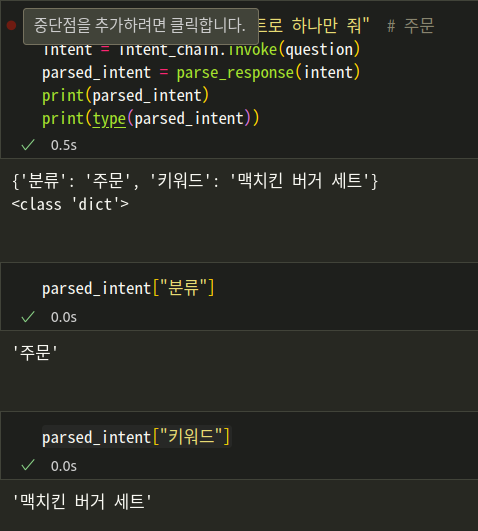

In [261]:
def process_keyword(word):
    word = ''.join(word)
    word = word.replace("세트", "").strip()
    word = word.replace("버거", "").strip()
    return word

In [268]:
def save_menu(keyword):
    menu_data = None

    # 데이터를 순회하면서 키워드와 일치하는 아이템을 찾음
    for item in data:
        if item['page_content']['name'] == keyword:
            menu_data = {
                "name": item['page_content']['name'],
                "category": item['page_content']['category'],
                "description": item['page_content']['description'],
                "price": item['page_content']['price'],
                "nutrition": item['page_content']['nutrition'],
                "origin": item['page_content']['origin']
            }
            break

    # JSON 형식으로 출력 (또는 이후에 사용)
    if menu_data:
        menu_data_json = json.dumps(menu_data, ensure_ascii=False, indent=4)
        print(menu_data_json)
        return menu_data_json
    else:
        print("해당 키워드와 일치하는 메뉴를 찾을 수 없습니다.")

In [ ]:
question = "빅맥 주문할게" 
intent = intent_chain.invoke(question)
parsed_intent = parse_response(intent)

category = parsed_intent.get('분류')
keyword = parsed_intent.get('키워드')  # 키워드가 없으면 None

In [242]:
print(category)
print(keyword)

주문
['빅맥']


keyword가 없거나, menu list에 없으면 추천시스템으로 넘어가기

In [406]:
recommend = False

if category == '주문':
    print(keyword)
    n_keyword = process_keyword(keyword)
    print(n_keyword)
    llm_keyword = name_chain.run(keyword)
    llm_keyword = process_keyword(llm_keyword)
    print(llm_keyword)
    if keyword is None:  # 키워드가 None일 경우 예외 처리
        recommend = True
        print("키워드 없음")
    elif llm_keywordi== "없음":
    else:
        try:
            if "세트" in keyword:  # 세트메뉴인 경우
                if n_keyword in menu_list:
                    save_menu(n_keyword)
                elif llm_keyword in menu_list:
                    save_menu(llm_keyword)
                else:  # 메뉴 리스트에 없는 항목
                    recommend = True
                    print("세트 없음")
            elif n_keyword in menu_list: # 단품메뉴인 경우
                save_menu(n_keyword)
            elif llm_keyword in menu_list:
                save_menu(llm_keyword)
            else:    # 단품 : 메뉴 리스트에 없는 항목
                recommend = True
                print("메뉴 없음")
        except Exception as e:  # 에러 발생 시 구체적인 에러 메시지를 출력
            print(f"에러 발생: {e}")
            recommend = True

베토디
베토디
베토디 스리라차 마요
메뉴 없음


In [259]:
print(find_name)

False


In [260]:
if find_name == False :
    print(menu_data)   

{
    "page_content": {
        "name": "빅맥",
        "category": "버거",
        "description": "100% 순 쇠고기 패티 두 장에 빅맥만의  특별한 소스.입안에서 살살 녹는 치즈와 신선한 양상추, 양파, 그리고 피클까지.50년 넘게 전 세계인의 입맛을 사로 잡은 버거의 대명사.",
        "price": "6300",
        "nutrition": {
            "중량(g)": "223g",
            "중량(ml)": "-",
            "열량": "582kcal",
            "당": "8g",
            "단백질": "27g",
            "포화지방": "11g",
            "나트륨": "902mg",
            "카페인": "-"
        },
        "origin": "쇠고기:호주산"
    }
}


### 주문내역 출력 -> 장바구니 넣기

In [351]:
# 주문데이터 장바구니에 넘겨주기
shopping_cart = []

def add_to_cart(order_data,num):
    cart["name"] = order_data["page_content"]["name"]
    cart["num"] = num
    cart["price"] = order_data["page_content"]["price"]
    shopping_cart.append(cart)

In [350]:
# # 예시로 주문 데이터를 사용하여 실행해봄
# order_data = {
#     "page_content": {
#         "name": "맥치킨",
#         "category": "버거",
#         "description": "바삭한 치킨 패티, 고소한 화이트 마요 소스와 아삭한 양상추가 함께!",
#         "price": "4300"
#     }
# }

# # 장바구니에 추가
# add_to_cart(order_data, 2)

# # 결과 출력
# print(shopping_cart)


[{'name': '맥치킨', 'num': 2, 'price': '4300'}]


### 비슷한 이름 LLM으로 추측

In [399]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4o-mini-2024-07-18", temperature=0.3)

# 프롬프트 템플릿 정의
prompt_template = PromptTemplate.from_template("""
사용자의 질문과 메뉴 리스트를 참고하여 사용자의 질문과 비슷한 메뉴가 있는지 확인하세요.
메뉴 리스트
비슷한 이름의 메뉴가 있다면 가장 비슷한 메뉴 이름 한개만 출력하세요.
비슷한 메뉴가 없다면 "없음"이라고 출력하세요.

<메뉴 리스트>
['맥크리스피 스리라차 마요', '베토디 스리라차 마요', '맥스파이시 상하이 버거', '토마토 치즈 비프 버거', '더블 쿼터파운더 치즈', '쿼터파운더 치즈', '빅맥', '맥크리스피 디럭스 버거', '맥크리스피 클래식 버거', '1955 버거', '맥치킨 모짜렐라', '맥치킨', '더블 불고기 버거', '불고기 버거', '슈슈 버거', '슈비 버거', '베이컨 토마토 디럭스', '치즈버거', '더블 치즈버거', '트리플 치즈버거', '햄버거', '소시지 스낵랩', '맥윙', '맥윙콤보', '코울슬로', '상하이 치킨 스낵랩', '골든 모짜렐라 치즈스틱', '후렌치 후라이', '맥너겟', '맥스파이시치킨 텐더', '해쉬 브라운', '애플 파이', '베리 스트로베리 맥플러리', '오레오 맥플러리', '딸기 오레오 맥플러리', '초코 오레오 맥플러리', '스트로베리콘', '아이스크림콘', '바닐라 선데이 아이스크림', '초코 선데이 아이스크림', '딸기 선데이 아이스크림', '오레오 아포가토', '바닐라 라떼', '아이스 바닐라 라떼', '카페라떼', '디카페인 카페라떼', '아이스 카페라떼', '디카페인 아이스 카페라떼', '아메리카노', '디카페인 아메리카노', '아이스 아메리카노', '디카페인 아이스 아메리카노', '카푸치노', '디카페인 카푸치노', '드립 커피', '아이스 드립 커피', '코카-콜라', '코카-콜라 제로', '스프라이트', '환타', '바닐라 쉐이크 Medium', '딸기 쉐이크 Medium', '초코 쉐이크 Medium', '오렌지 주스', '생수']
</메뉴 리스트>

<질문>
{question}
</질문>

""")

# LLMChain을 사용하여 프롬프트와 LLM을 연결
name_chain = LLMChain(llm=llm, prompt=prompt_template, output_parser=StrOutputParser())

In [ ]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI
from langchain.schema import BaseOutputParser
import json

# 커스텀 출력 파서 정의
class CustomOutputParser(BaseOutputParser):
    def parse(self, text: str) -> dict:
        # 항상 'answer' 키로 '정답'을 반환
        return {"answer": text.strip()}

llm = ChatOpenAI(model_name="gpt-4o-mini-2024-07-18", temperature=0.3)

# 프롬프트 템플릿 정의
prompt_template = PromptTemplate.from_template("""
사용자의 질문과 메뉴 리스트를 참고하여 사용자의 질문과 비슷한 메뉴가 있는지 확인하세요.
메뉴 리스트
비슷한 이름의 메뉴가 있다면 가장 비슷한 메뉴 이름 한개만 출력하세요.
비슷한 메뉴가 없다면 "없음"이라고 출력하세요.

<메뉴 리스트>
['맥크리스피 스리라차 마요', '베토디 스리라차 마요', '맥스파이시 상하이 버거', '토마토 치즈 비프 버거', '더블 쿼터파운더 치즈', '쿼터파운더 치즈', '빅맥', '맥크리스피 디럭스 버거', '맥크리스피 클래식 버거', '1955 버거', '맥치킨 모짜렐라', '맥치킨', '더블 불고기 버거', '불고기 버거', '슈슈 버거', '슈비 버거', '베이컨 토마토 디럭스', '치즈버거', '더블 치즈버거', '트리플 치즈버거', '햄버거', '소시지 스낵랩', '맥윙', '맥윙콤보', '코울슬로', '상하이 치킨 스낵랩', '골든 모짜렐라 치즈스틱', '후렌치 후라이', '맥너겟', '맥스파이시치킨 텐더', '해쉬 브라운', '애플 파이', '베리 스트로베리 맥플러리', '오레오 맥플러리', '딸기 오레오 맥플러리', '초코 오레오 맥플러리', '스트로베리콘', '아이스크림콘', '바닐라 선데이 아이스크림', '초코 선데이 아이스크림', '딸기 선데이 아이스크림', '오레오 아포가토', '바닐라 라떼', '아이스 바닐라 라떼', '카페라떼', '디카페인 카페라떼', '아이스 카페라떼', '디카페인 아이스 카페라떼', '아메리카노', '디카페인 아메리카노', '아이스 아메리카노', '디카페인 아이스 아메리카노', '카푸치노', '디카페인 카푸치노', '드립 커피', '아이스 드립 커피', '코카-콜라', '코카-콜라 제로', '스프라이트', '환타', '바닐라 쉐이크 Medium', '딸기 쉐이크 Medium', '초코 쉐이크 Medium', '오렌지 주스', '생수']
</메뉴 리스트>

<질문>
{question}
</질문>

""")
# 커스텀 출력 파서를 적용
output_parser = CustomOutputParser()

# LLMChain을 사용하여 프롬프트와 LLM을 연결
name_chain = LLMChain(llm=llm, prompt=prompt_template, output_parser=output_parser)

In [400]:
keyword = "맥크리스탈 마요"
name_chain.run(keyword)

'맥크리스피 스리라차 마요'

In [402]:
keyword = "맥크리스탈"
name_chain.run(keyword)

'없음'

In [403]:
keyword = "스파이시"
name_chain.run(keyword)

'맥스파이시 상하이 버거'

In [404]:
keyword = "베토디"
name_chain.run(keyword)
# 베이컨 토마토 디럭스도 있음.. ㅜㅜ 

'베토디 스리라차 마요'

In [ ]:
from langchain.prompts import ChatPromptTemplate

order_single_template = ChatPromptTemplate.from_messages([
    ("system",
    """
    당신은 맥도날드 가게의 점원입니다. 
    나이가 많은 노인 고객의 주문을 도와주세요.
    나이와 관련된 어떤한 호칭도 하지 말고 '고객님'으로 부르세요.
    어린아이도 이해하기 쉬운 단어로 설명해주세요.
    상냥하고, 친절하고, 존댓말로 사용자의 질문에 답변을 해주세요. 
    간결하게 답변하며, 가능한 한문장 이내로 대답해주세요.
    
    반드시 제공된 정보만을 사용하여 질문에 대답하세요.
    질문과 가장 관련성이 높은 메뉴를 찾아서 답변하세요.
    충분한 정보를 바탕으로 정확히 답변할 수 있는 경우에만 답변하세요.
    한가지 메뉴로 특정할 수 없는 경우, 추가질문을 통해 메뉴를 특정하세요.

    답변이 확실하지 않을 경우, "죄송합니다. 해당 질문에 대한 답을 찾을 수 없습니다."라고 답하세요.
    
    주문 결과를 json 형식으로 출력합니다.

    주문 결과 예시: 
    {{
        "주문 메뉴" : [
            {{
                "메뉴 이름" : "베이컨 토마토 디럭스"
                
            }}
        ]
    }}
    Context: {context}
    """),
    ("human", "{question}"),
])

In [ ]:
from langchain.prompts import ChatPromptTemplate

order_set_template = ChatPromptTemplate.from_messages([
    ("system",
    """
    당신은 맥도날드 가게의 점원입니다. 
    나이가 많은 노인 고객의 주문을 도와주세요.
    나이와 관련된 어떤한 호칭도 하지 말고 '고객님'으로 부르세요.
    어린아이도 이해하기 쉬운 단어로 설명해주세요.
    상냥하고, 친절하고, 존댓말로 사용자의 질문에 답변을 해주세요. 
    간결하게 답변하며, 가능한 한문장 이내로 대답해주세요.
    
    반드시 제공된 정보만을 사용하여 질문에 대답하세요.
    질문과 가장 관련성이 높은 메뉴를 찾아서 답변하세요.
    충분한 정보를 바탕으로 정확히 답변할 수 있는 경우에만 답변하세요.
    한가지 메뉴로 특정할 수 없는 경우, 추가질문을 통해 메뉴를 특정하세요.

    답변이 확실하지 않을 경우, "죄송합니다. 해당 질문에 대한 답을 찾을 수 없습니다."라고 답하세요.
    
    주문 결과를 json 형식으로 출력합니다.

    주문 결과 예시: 
    {{
        "주문 메뉴" : [
            {{
                "메뉴 이름" : "베이컨 토마토 디럭스",
                "추가 옵션" : "후렌치 후라이 1개, 코카콜라 1개",
                "단품 금액" : 6600,
                "추가 금액" : 5600,
                "주문 금액" : 12200
            }}
        ]
    }}
    Context: {context}
    """),
    ("human", "{question}"),
])

In [7]:
from langchain.prompts import ChatPromptTemplate

rec_template = ChatPromptTemplate.from_messages([
    ("system",
    """
    당신은 맥도날드 가게의 점원입니다. 
    나이가 많은 노인 고객의 주문을 도와주세요.
    나이와 관련된 어떤한 호칭도 하지 말고 '고객님'으로 부르세요.
    어린아이도 이해하기 쉬운 단어로 설명해주세요.
    상냥하고, 친절하고, 존댓말로 사용자의 질문에 답변을 해주세요. 
    간결하게 답변하며, 가능한 한문장 이내로 대답해주세요.
    
    반드시 제공된 정보만을 사용하여 질문에 대답하세요.
    질문과 가장 관련성이 높은 메뉴를 찾아서 답변하세요.
    충분한 정보를 바탕으로 정확히 답변할 수 있는 경우에만 답변하세요.
    한가지 메뉴로 특정할 수 없는 경우, 추가질문을 통해 메뉴를 특정하세요.

    답변이 확실하지 않을 경우, "죄송합니다. 해당 질문에 대한 답을 찾을 수 없습니다."라고 답하세요.
    
    주문의 절차는 다음과 같습니다 : 
    1. 고객의 주문을 받습니다.
    2. 버거 메뉴를 선택할 때 항상 세트 메뉴를 원하는지 확인합니다. 
       세트 메뉴는 버거, 사이드, 음료가 포함됩니다. 
       기본 사이드는 후렌치 후라이 1개, 음료는 콜라 1개입니다. 사이드와 음료는 변경 가능합니다.
       다른 메뉴로 변경 시 추가 금액을 안내해 드립니다.
    4. 주문 완료 시 주문을 검토합니다.
    5. 주문 결과를 json 형식으로 출력합니다.

    주문 결과 예시: 
    {{
        "주문 메뉴" : [
            {{
                "메뉴 이름" : "베이컨 토마토 디럭스",
                "추가 옵션" : "후렌치 후라이 1개, 코카콜라 1개",
                "단품 금액" : 6600,
                "추가 금액" : 5600,
                "주문 금액" : 12200
            }}
        ]
    }}
    Context: {context}
    """),
    ("human", "{question}"),
])

In [ ]:
file_dir = "/home/yoojin/ML/aiffel/HackaThon/modu_hackaton/LLM/files/menu_1014.json"

with open(file_dir, 'r', encoding='utf-8') as file:
    content = file.read()
    # JSON 객체들을 리스트로 변환
    json_objects = json.loads(content)

# 파싱된 JSON 객체들을 문서로 변환
docs = [
    Document(
        page_content=json.dumps(obj['page_content'], ensure_ascii=False),
    )
    for obj in json_objects
]


file_name = file_dir.split("/")[-1]
cache_dir = LocalFileStore(f"./.cache/embeddings/{file_name}")

# CharacterTextSplitter를 사용하여 문서 분할
text_splitter = CharacterTextSplitter(separator="\n\n", chunk_size=100, chunk_overlap=0)
split_docs = text_splitter.split_documents(docs)

embeddings = UpstageEmbeddings(
    model="solar-embedding-1-large"
)

cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    underlying_embeddings=embeddings,
    document_embedding_cache=cache_dir,
    namespace="solar-embedding-1-large",
)
vectorstore = FAISS.from_documents(
    split_docs,
    cached_embedder,
)

faiss = vectorstore.as_retriever(search_kwargs={"k": 4})

bm25 = BM25Retriever.from_documents(split_docs)
bm25.k = 4

ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25, faiss],
    weights=[0.3, 0.7],
    search_type="mmr",
)

In [10]:
llm = ChatAnthropic(model_name="claude-3-5-sonnet-20240620")

order_chain = {
    "context": ensemble_retriever,
    "question": RunnablePassthrough()
} | order_template | llm

In [11]:
order_chain.invoke("치킨버거 주문할게")

AIMessage(content='네, 고객님. 치킨버거 주문 감사합니다. 저희 매장에는 맥치킨과 맥크리스피 클래식 버거, 두 가지 치킨버거가 있습니다. 어떤 버거를 원하시나요?', additional_kwargs={}, response_metadata={'id': 'msg_01CtbVTDr7gm3ZEcV6Lf5LrZ', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 2278, 'output_tokens': 90}}, id='run-7279336d-7620-44df-8877-7e11bcc73c4b-0', usage_metadata={'input_tokens': 2278, 'output_tokens': 90, 'total_tokens': 2368})